## [LG 전자] 자연어 처리 # 3 : 감성분석 - (2)

* 모델 기반의 감성문석 모델 구축
* 예상 난이도 ⭐️⭐️⭐️


## 강의 복습

강의자료 : 자연어처리 3, AGENDA 04 - 모델 기반 접근 2 : CNN / RNN

## 실습 요약

1. 본 실습에서는 TextCNN을 활용하여 감성분석 모델을 구축합니다
2. 학습된 모델을 활용하여 평가를 진행합니다.
3. Captum library를 활용하여 리뷰에서 중요한 감성어휘와 구를 추출합니다.


------

### STEP 0. 환경 구축하기
* 필요한 library들을 import 합니다

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import sys
import json
import random
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
#%matplotlib inline #생성한 figure를 notebook에서 볼 수있게 해주는 코드

import gensim
import torch
import torch.nn as nn # nn: deeplearning model에 필요한 module 패키지
import torch.optim as optim # optim : model 학습에 관련된 optimizing method 패키지
import torch.nn.functional as F # F : 학습에 사용할 수 있는 함수 패키지

#check torch version & device
print ("Python version:[%s]."%(sys.version))
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device)) # device에 cuda:0가 프린트 된다면 GPU를 사용하는 상태입니다

Python version:[3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]].
PyTorch version:[1.10.0+cu111].
device:[cuda:0].


In [ ]:
! pip install konlpy -q
! pip install captum -q

     |████████████████████████████████| 19.4 MB 7.2 MB/s 
     |████████████████████████████████| 448 kB 43.9 MB/s 
     |████████████████████████████████| 1.4 MB 5.3 MB/s 


In [ ]:
# set random seed 

def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

### STEP 1. 데이터 준비하기
금일 실습에서는 **Naver_shopping**에서 수집된 **리뷰 데이터**를 활용합니다.
* 제품별 후기를 별점과 함께 수집한 데이터
* 데이터셋 출처

  * 1) https://github.com/songys/AwesomeKorean_Data
  * 2) https://github.com/bab2min/corpus/tree/master/sentiment


* 해당 실습에서는 전체 데이터 중 50%인 10만개의 데이터를 사용함 (긍정 : 50000개, 부정 : 50000개)





In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/KU-DIC/LG_natural_language_processing_day22

In [ ]:
# 데이터셋 읽기
with open('./LG_natural_language_processing_day22/data/naver_shopping.txt','r',encoding='utf-8') as f:
  data = f.readlines()

In [ ]:
# 분석에 사용할 형태로 가공하기
rate = []
label = []
sentence = []
for cur_review in tqdm(data):
  # 평점과 리뷰 문장 분리
  cur_review = cur_review.split('\t')
  # 평점
  rate.append(cur_review[0])
  # 리뷰 문장
  sentence.append(cur_review[1].strip('\n'))
  # 평점 4,5 : Positive, 
  # 평점 1,2 : Negative
  if int(cur_review[0]) >3:
    label.append(0) # positive
  else:
    label.append(1) # negative

100%|██████████| 200000/200000 [00:00<00:00, 618139.32it/s]


In [ ]:
# 데이터 프레임 형태로 변환하기
df = {
    "rate" : rate,
    "label" : label,
    "sentence" : sentence
}
df = pd.DataFrame(df)
df = df.sample(frac=0.5,replace=False, random_state=42)

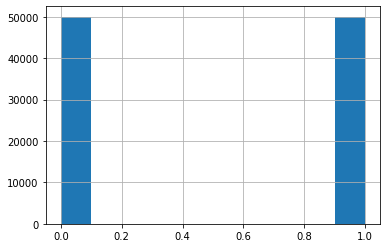

In [ ]:
df['label'].hist()

In [ ]:
df.head()

,rate,label,sentence
119737,2,1,마감이 안좋아요...실밥도 많고 바느질도 부족한 부분이 몇군데 있네요...교환받기 ...
72272,5,0,깨끗하게 잘 다듬어져 있어요. 맛도좋고요.
158154,4,0,재구매 배송빨라요 길냥이들이 잘먹어요~~ 대용량이라 좋네요~
65426,5,0,제품도 빨리 배송해주시고 꼼꼼하게 잘챙겨주셨어요
30074,5,0,기타 남 멋지고 예뻐요 여러 사은품도 좋아요


여기서부터 다시 시작하면 됨 

### STEP 2. 전처리 진행 (Preprocessing)

In [ ]:
review_sentences = df['sentence'].to_list()

In [ ]:
import re
def preprocess(text):
  text = re.sub('[-=+,#/\?:^$~@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','', text)
  text = re.sub('[ㅠㅎㅋ]','', text)
  return text

In [ ]:
normalize_sentence = []
for sentence in tqdm(review_sentences):
  sentence = preprocess(sentence)
  normalize_sentence.append(sentence)

df['normalize_sentence'] = normalize_sentence

100%|██████████| 100000/100000 [00:00<00:00, 252630.26it/s]


### STEP 3. 토큰화 진행 (Tokenization)

In [ ]:
# Okt(Open Korea Text)
from konlpy.tag import Okt  
okt = Okt() 

tokenized_sentence = []
for sent in tqdm(normalize_sentence):
  sent = okt.morphs(sent)
  tokenized_sentence.append(sent)

100%|██████████| 100000/100000 [07:16<00:00, 229.05it/s]


In [ ]:
df['tokenized_sentence'] = tokenized_sentence

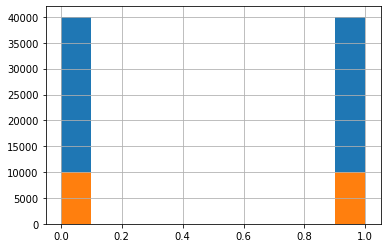

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size =0.2, random_state= 42)
train_df['label'].hist()
test_df['label'].hist()

In [ ]:
train_df['len'] = train_df['tokenized_sentence'].apply(lambda x: len(x))

In [ ]:
train_df['len'].describe()

count    80000.000000
mean        14.912112
std         11.169106
min          1.000000
25%          7.000000
50%         11.000000
75%         21.000000
max         77.000000
Name: len, dtype: float64

### STEP 4. 벡터화 진행 (Vectorization)
* 해당 실습에서는 FastText를 활용하여 벡터화를 수행함
* 한국어에 대해 사전학습을 수행한 FastText 벡터가 존재하나, 해당 실습에서는 사용하지 않음
* 실습에서 사용하지 않는 이유 : 다운로드, 용량 (4GB)
  

In [ ]:
%%time
from gensim.models import FastText

model = FastText(
    sentences = tokenized_sentence,
    size=100,
    window=5,
    min_count=1,
    workers=4)

CPU times: user 1min 7s, sys: 1.21 s, total: 1min 8s
Wall time: 48.8 s


In [ ]:
vocab = list(model.wv.vocab)
train_sentence = train_df['tokenized_sentence'].to_list()
test_sentence = test_df['tokenized_sentence'].to_list()

In [ ]:
# vocab

In [ ]:
word2index = {'<PAD>':0, '<UNK>':1}

for v in vocab: # v는 vocab 객체 하나를 의미함
  if word2index.get(v) is None:
    word2index[v] = len(word2index) # 단어별 index 부여

index2word = {}
for idx, vo in word2index.items():
  index2word[vo] = idx

# 한줄로 구현하기
# index2word = {v:idx for idx, v in word2index.items()}

In [ ]:
fasttext_vector = []
for key in word2index.keys():
  if key in '<PAD>' or '<UNK>': # 두가지 단어는 vocab에 속하지 않음 
    fasttext_vector.append(np.random.randn(100,)) # random한 값으로 초기화 하여 제공
  else:
    fasttext_vector.append(model.wv[key])
  
fasttext_matrix = np.vstack(fasttext_vector)

In [ ]:
print('vocab 개수 : ',len(vocab))
print('word matrix shape : ',fasttext_matrix.shape) # '<PAD>''<UNK>'를 추가해주었기 때문에 vocab보다 2개 많은 상태

vocab 개수 :  76908
word matrix shape :  (76910, 100)


### STEP 5. 모델 구축하기 (Modeling)
* TextCNN을 활용하여 감성분석 모델 만들기
* 딥러닝 모델을 학습하기 위해서는 Dataset, Dataloader를 생성해야함


In [ ]:
from torch.utils.data import Dataset, DataLoader

class TextCNNDataset(Dataset):
  def __init__(self, df, tokenizer, word2index, max_seq_length=100):
    self.max_seq_length = max_seq_length
    # self.tokenizer = tokenizer
    self.df = df
    self.word2index = word2index
    self.inputs = df["tokenized_sentence"].to_list() # input sentence는 input 혹은 source라는 단어로 표현됨
    self.targets = df["label"].to_list() # output label은 target으로 표현됨

  def convert_inputs_to_feature(self, input):
    # STEP 1 : word to index
    # 문장을 token 단위로 분리한 후, 모델이 이해할 수 있는 형태인 숫자로 바꾸어줍니다
    tokenized_input = []
    for cur_word in input:
      try:
        tokenized_input.append(self.word2index[cur_word])
      except:
        tokenized_input.append(self.word2index['<UNK>'])

    # STEP 2 : pad or truncate token
    # max length에 따라 input 문장의 길이 조절하여 동일한 길이의 input으로 변환
    # batch단위로 학습을 하기위해 다음과 같은 과정을 거침
    diff = self.max_seq_length - len(tokenized_input)
    if diff > 0:
      tokenized_input += [self.word2index['<PAD>']]*diff 
    else:
      tokenized_input = tokenized_input[:self.max_seq_length]
    
    return tokenized_input

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    input = self.inputs[idx]
    target = self.targets[idx]

    tokenized_input = self.convert_inputs_to_feature(input)

    assert len(tokenized_input) == self.max_seq_length

    batch = [
             torch.tensor(tokenized_input),
             torch.tensor(target)
    ]
    return batch

In [ ]:
class TextCNN(nn.Module):
  def __init__(self, vocab_size, embedding_dim, kernel_dim, kernel_sizes=(3,4,5), dropout_rate=0.5, num_class=2):
      super(TextCNN, self).__init__()

      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])

      # kernal_size = (K,D) 
      self.dropout = nn.Dropout(dropout_rate)
      self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, num_class)
  
  def pretrained_weights(self, pretrained_word_vectors, is_static=False):
      self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
      if is_static:
          self.embedding.weight.requires_grad = False
      
  def forward(self, inputs):
      emb_output = self.embedding(inputs).unsqueeze(1)
      con_output = [conv(emb_output) for conv in self.convs]
      pool_output = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_output]
      
      concated = torch.cat(pool_output, dim=1)
      concated = concated.squeeze(-1)
      concated = self.dropout(concated)

      output = self.fc(concated) # model output
      return F.log_softmax(output,1) # softmax output

In [ ]:
# train
EPOCH = 5
BATCH_SIZE = 500
KERNEL_SIZES = [3,4,5]
KERNEL_DIM = 100
LR = 0.001

In [ ]:
train_dataset = TextCNNDataset(
    df = train_df,
    tokenizer = okt, 
    word2index = word2index, 
    max_seq_length=30)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle=False,
    )

In [ ]:
model = TextCNN(
    vocab_size = len(word2index), 
    embedding_dim = 100, 
    kernel_dim = KERNEL_DIM, 
    kernel_sizes = KERNEL_SIZES, 
    dropout_rate=0.5, 
    num_class=2
    )

model.pretrained_weights(fasttext_matrix) # initialize embedding matrix using pretrained vectors

model = model.to(device)
    
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [ ]:
model.train()
for epoch in range(EPOCH):
    batch_loss = []
    for step, batch in enumerate(train_loader):
        inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)
        
        model.zero_grad()
        preds = model(inputs)
        
        loss = loss_function(preds, targets)
        batch_loss.append(loss.item())
        loss.backward()
        
        #for param in model.parameters():
        #    param.grad.data.clamp_(-3, 3)
        
        optimizer.step()
        optimizer.zero_grad()
        if step % 100 == 0:
            print('[%d/%d] [%d/%d] %f' % (epoch, EPOCH, step, len(train_loader), loss.item()))

  0%|          | 0/5 [00:00<?, ?it/s]

[0/5] mean_loss : 0.55


 20%|██        | 1/5 [00:09<00:38,  9.61s/it]

[1/5] mean_loss : 0.39


 40%|████      | 2/5 [00:18<00:28,  9.46s/it]

[2/5] mean_loss : 0.32


 60%|██████    | 3/5 [00:28<00:18,  9.40s/it]

[3/5] mean_loss : 0.28


 80%|████████  | 4/5 [00:37<00:09,  9.52s/it]

[4/5] mean_loss : 0.25


100%|██████████| 5/5 [00:47<00:00,  9.48s/it]


In [ ]:
# test

test_dataset = TextCNNDataset(
    df = test_df,
    tokenizer = okt, 
    word2index = word2index, 
    max_seq_length=30)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle=False,
    )

In [ ]:
model.eval()

model_prediction = []
test_label = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)
        
        preds = model(inputs)
        preds = np.argmax(preds.cpu().detach().numpy(),axis=1)
        targets = targets.cpu().detach().numpy()

        model_prediction.extend(preds)
        test_label.extend(targets)
        assert len(model_prediction) == len(test_label)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# 성능 평가하기
print('Test data f1 score : ',f1_score(test_label, model_prediction, average='macro'))
print('Test data accuracy score : ',accuracy_score(test_label, model_prediction))

Test data f1 score :  0.8824439902428911
Test data accuracy score :  0.88245


### STEP 6. CAPTUM을 활용하여 키워드 추출해보기

In [ ]:
# captum

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

lig = LayerIntegratedGradients(model, model.embedding)

In [ ]:
# accumalate couple samples in this array for visualization purposes
softmax=nn.Softmax(dim=1)

def interpret_sentence(model, word2index, input, max_len = 10, label = 0):
    token_reference = TokenReferenceBase(reference_token_idx=word2index['<PAD>'])

    tokenized_input = []
    for cur_word in input:
      try:
        tokenized_input.append(word2index[cur_word])
      except:
        tokenized_input.append(word2index['<UNK>'])

    diff = max_len - len(tokenized_input)
    if diff > 0:
      tokenized_input += [word2index['<PAD>']]*diff 
    else:
      tokenized_input = tokenized_input[:max_len]

    model.zero_grad()

    input_indices = torch.tensor(tokenized_input, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = max_len

    # predict
    pred = model(input_indices)
    pred = softmax(pred).squeeze(0)
    pred = pred.cpu().detach().numpy()
    pred_ind = np.argmax(pred,axis=0)
    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)
    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, label,\
                                           n_steps=500, return_convergence_delta=True)

    label_dict = { 0:'positive', 1:'negative'}

    print('pred: ', label_dict[pred_ind], '(', pred[pred_ind], ')')

    vis_data_records,attributions = add_attributions_to_visualizer(attributions_ig, input, pred, pred_ind, label_dict, label, delta, vis_data_records_ig)
    return vis_data_records,attributions

def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label_dict,label, delta, vis_data_records):
    vis_data_records = []
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred[pred_ind],
                            label_dict[pred_ind],
                            label_dict[label],
                            label_dict[label],
                            attributions.sum(),
                            text,
                            delta))
    return vis_data_records , attributions

In [ ]:
input = ['배송', '도', '빠르고', '상품', '도', '맘', '에', '들어요']
vis_data_records, attributions = interpret_sentence(model, word2index, input, label=0)
_ = visualization.visualize_text(vis_data_records)

pred:  positive ( 0.99918824 )


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
positive,positive (1.00),positive,1.56,배송 도 빠르고 상품 도 맘 에 들어요


In [ ]:
input = ['생각', '보다', '별로', '네', '여']
vis_data_records, attributions = interpret_sentence(model, word2index, input, label=1)
_ = visualization.visualize_text(vis_data_records)

pred:  negative ( 0.9948396 )


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
negative,negative (0.99),negative,0.70,생각 보다 별로 네 여
